<a href="https://colab.research.google.com/github/mobarakol/DL_Robotic_AI/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Tech-Watt/Faster-RCNN-PYTORCH.git
%cd Faster-RCNN-PYTORCH

Cloning into 'Faster-RCNN-PYTORCH'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 922.23 KiB | 23.65 MiB/s, done.
/content/Faster-RCNN-PYTORCH


In [12]:
!pip -q install cvzone datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00


Training:

In [22]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import numpy as np

# Load CPPE-5 dataset from Hugging Face
dataset = load_dataset("cppe-5", split="train")

# Define dataset class
class ObjectDetectionDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        # Load image
        image = data['image'].convert("RGB")

        # Extract bounding boxes and labels correctly
        boxes = []
        labels = []
        for annotation in data['objects']['bbox']:  # FIXED: Correct bbox access
            x_min, y_min, width, height = annotation  # bbox is a list
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])

        # Extract category labels correctly
        labels = data['objects']['category']  # FIXED: Extract category labels correctly

        # Convert to PyTorch tensors
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

# Define transformations
transform = T.Compose([
    T.ToTensor(),
    T.Resize((512, 512)),
])

# Prepare dataset and dataloader
train_dataset = ObjectDetectionDataset(dataset, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.train()

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

print("Training Completed!")

# Save the trained model
torch.save(model.state_dict(), "faster_rcnn_cppe5.pth")


Epoch [1/5], Loss: 2588.8821
Epoch [2/5], Loss: 2221.5882
Epoch [3/5], Loss: 2095.7725
Epoch [4/5], Loss: 2004.4497
Epoch [5/5], Loss: 2078.8463
Training Completed!


Testing:

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'numpy.ndarray'>
<class 'torch.Tensor'>


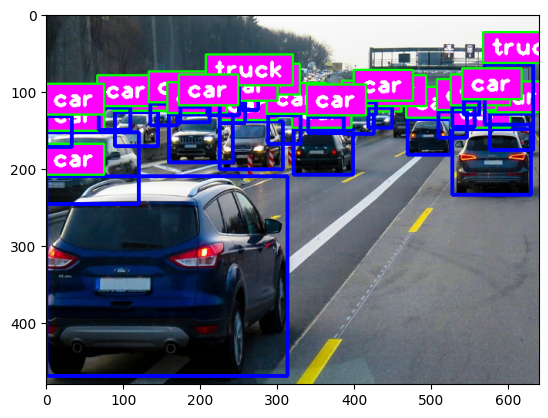

In [10]:
import torch
import cvzone
import cv2
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import requests
from PIL import Image
import numpy as np

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
model.eval()

classnames = []
with open('classes.txt','r') as f:
    classnames = f.read().splitlines()


# URL of the image
image_url = "https://p1.pxfuel.com/preview/411/31/645/traffic-jam-vehicles-highway.jpg"

# Fetch the image
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
image = cv2.resize(np.array(image),(640,480))

image_transform = transforms.ToTensor()
img = image_transform(image)
print(type(image))
print(type(img))

with torch.no_grad():
    pred = model([img])
    bbox,scores,labels = pred[0]['boxes'],pred[0]['scores'],pred[0]['labels']
    conf = torch.argwhere(scores > 0.70).shape[0]
    for i in range(conf):
        x,y,w,h = bbox[i].numpy().astype('int')
        classname = labels[i].numpy().astype('int')
        class_detected = classnames[classname]
        cv2.rectangle(image,(x,y),(w,h),(0,0,255),4)
        cvzone.putTextRect(image,class_detected,[x+8,y-12],scale=2,border=2)
        cv2.imwrite('data1.png',image)


plt.imshow(image)

In [ ]:
plt.imshow(image)